In [7]:
import os
import pandas as pd
import numpy as np
import spacy
import string


datapath = os.path.join(os.path.dirname(os.getcwd()), 'data')

food_df = pd.read_csv(os.path.join(datapath, 'RNN_1_data.csv'))
food_df.head(5)

Unnamed: 0                                      texts               foods  \
0           0                                        Hi.                  []   
1           1                        How can I help you?                  []   
2           2  What would you like to order in Barbecue?        ['Barbecue']   
3           3      Yeah, I'd like to get a rack of ribs.  ['a rack of ribs']   
4           4    What kind of sides can I get with that?                  []   

                annotations  labels  
0                        []       0  
1                        []       0  
2  ['food_order.type.food']       1  
3  ['food_order.name.item']       1  
4                        []       0

In [8]:
### pretvaranje tokena u vektore ###
### u ovom koraku koristimo transfer learning - uzimamo pred-trenirane vektore iz nekog od postojećih resursa 
                                                # (spacy, google-news ili stanfordfov GloVe ili neki drugi)
### potrebno je za svaki token dobiti značajke
    # to je potrebno bez obzira radili token-level klasifikator ili sequence/sentence level 
        # (tj. radimo li oznake/labele za svaki token pojedinačno ili su oznake/labele na nizove tokena)

from nlp_functions import spacy_parser
nlp = spacy.load("en_core_web_lg")

tokens = []
vectors = []
for idx,row in food_df.iterrows():
    t,v = spacy_parser(nlp,row['texts'])
    tokens.append(t)
    vectors.append(v)


# test #
print(food_df['texts'][1111])
print(vectors[1111])


### splitane tokene dodajemo u dataframe 
food_df['tokens'] = tokens

Awesome, thank you.
[array([ 1.6907e+00, -2.0116e+00, -1.7221e+00, -2.3530e+00,  2.3004e+00,
       -4.1463e-01,  1.7109e+00,  1.4429e-02, -2.0794e+00, -4.2896e-01,
       -5.5037e-01,  1.3442e+00, -3.3321e+00, -3.5583e-01,  1.0879e+00,
        1.4114e-01,  1.4038e+00,  9.6698e-01, -1.3234e+00,  6.1780e-01,
        7.0016e-01,  2.7516e+00, -1.0783e-01, -1.2513e+00,  6.3628e-01,
        1.7929e+00, -2.0169e+00, -1.0323e+00, -2.0094e-01,  8.3985e-02,
       -2.3067e-01,  8.0747e-02, -7.3571e-01,  6.0127e-01,  4.1722e-01,
       -1.2910e+00,  2.2381e-01, -1.8747e+00,  2.6069e+00, -1.5025e+00,
        2.1644e+00,  1.0491e+00, -1.4447e+00, -7.9628e-01, -1.4046e-01,
        8.3066e-01,  1.3105e-01, -1.4730e+00,  7.2793e-01,  2.5035e+00,
        1.3469e+00, -6.9462e-01, -1.3186e+00, -1.9587e+00,  3.7880e-01,
        1.1133e+00, -9.8936e-01, -2.3262e-01,  1.6703e-01,  1.6915e+00,
        3.3767e-01,  1.6098e+00,  5.5199e-01, -4.4592e-01, -6.2240e-01,
        1.4902e+00, -3.8676e+00, -2.4327e+0

In [10]:
print(food_df['tokens'].sample(3))

10466    [Yes, ., That, 's, it, .]
10214              [Thank, you, .]
12639                   [Hello, .]
Name: tokens, dtype: object


In [11]:
def get_labels_from_text(df):
    '''
    ova funkcija koristi tekst kao input i za splitane tokene provjerava labele - ne koristimo ju.
    '''
    labels = []
    for idx,row in df.iterrows():
        row_labels = []
        for t in (row['texts']).split(' '):
            # čistimo tokene od interpunkcije
            no_punct_t = t.translate(str.maketrans('', '', string.punctuation))
            if no_punct_t in row['foods']:
                row_labels.append(1)
            else:
                row_labels.append(0)

        labels.append(row_labels)

    df['labels'] = labels
    return labels


### Sve ovisi o tome kakav preprocessing napravite (stopwords, interpunkcije itd itd) 
    # - pazite samo da pozicija labele odgovara stvarnoj poziciji tokena/vektora
    # interpunkcije isto mogu imati svoje vektore !! 
    # kod ovog je modela potrebno napraviti još preprocessinga i provjera odgovaraju li pozicije tokena pozicijama labela

### U ovom koraku je bitno da poziciju tokena kodirate s nekom klasom (0-nije food,1-food,2-pad)


from preprocessing import encode_labels_from_tokens

labels = encode_labels_from_tokens(food_df)

food_df.head(5)

Unnamed: 0                                      texts               foods  \
0           0                                        Hi.                  []   
1           1                        How can I help you?                  []   
2           2  What would you like to order in Barbecue?        ['Barbecue']   
3           3      Yeah, I'd like to get a rack of ribs.  ['a rack of ribs']   
4           4    What kind of sides can I get with that?                  []   

                annotations                                labels  \
0                        []                                [0, 1]   
1                        []                    [0, 0, 0, 0, 0, 1]   
2  ['food_order.type.food']           [0, 0, 0, 0, 0, 0, 0, 1, 1]   
3  ['food_order.name.item']  [0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]   
4                        []        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]   

                                              tokens  
0                                            [Hi, .]  
1                        [How, can, I, help, you, ?]  
2  [What, would, you, like, to, order, in, Barbec...  
3  [Yeah, ,, I, 'd, like, to, get, a, rack, of, r...  
4  [What, kind, of, sides, can, I, get, with, tha...

In [12]:
### provjeravamo jesu li liste tokena - koje smo vektorizirali ranije i labela jednako duge
for i,text in enumerate(vectors):
    assert len(vectors[i]) == len(labels[i]) == len(tokens[i])

In [13]:
### Moramo odrediti nekakvu maksimalnu dužinu svakog sequencea - retka pod food_df['texts']
# stari token count je imao drugačiji preprocessing (vidi funkciju u preprocessing.py)

food_df['TokenCount'] = food_df['tokens'].str.len()
max_len = food_df['TokenCount'].max()
print(max_len)

### inače se preporuča da embedding size bude potencija broja 2 (64 ili 128) ili kombinacija istih
### slobodno možete plotati distribuciju dužine rečenica/tekstova (to bi bio sequence length ili input size ulaznih podataka) 
    # zato što želite smanjiti input size, a zadržati što više podataka

    
max_len = 32


116


In [14]:
### RUČNI PADDING ### 

### --> cilj je do neke max dužine N dodati 'dummy' podatke kako bi svi inputi bili jednako veliki 
### --> dakle, tekstovima koji imaju 25 tokena dodajemo max_len - 25 padding tokena 
### --> isto to i za labele
### zašto? --> želimo napraviti pravilne matrice (13953 * dužina tekstova(sequences) * veličina pojedinog vektora (300))

embeddings = []
enc_labels = []

for i,text in enumerate(vectors):
    seq = []
    l = []

    if len(text) > max_len:
        seq = text[:max_len]
        l = labels[i][:max_len]
    else:
        seq.extend(text)
        l.extend(labels[i])
        while len(seq) < max_len:
            seq.append(np.zeros((300,), dtype=np.float32))
            l.append(2)

    embeddings.append(seq)
    enc_labels.append(l)

print("rečenica 128:", len(embeddings[128]))
print("dužina vektora za prvi token u rečenici 1111:", len(embeddings[1111][0]))
print(enc_labels[1111][0])
print(enc_labels[1111])
print(food_df['texts'][1111]) # obratite pozornost kako spacy i interpunkcijama daje vektor...

rečenica 128: 32
dužina vektora za prvi token u rečenici 1111: 300
0
[0, 1, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Awesome, thank you.


In [15]:
### Još par provjera za dužine lista i tipove podataka koje očekujemo:

# print(enc_labels)
print(len(enc_labels))
for seq in enc_labels:
    if len(seq) != max_len:
        print("nije max_len:", len(seq))
    if not isinstance(seq, list):
        print(type(seq))
    for idx,l in enumerate(seq):
        # print(len(l)) # --> 1 if list; error if int (no len() for int)

        if not isinstance(l, int):
            print("idx:", idx, type(l))
        else:
            if l > 3:
                print(l)

13953


In [16]:
### pretvaramo input datu u matrice ili tensore
# ako ovdje dobivate error, vjerojatno je do nekompatibilnosti tensorflowa s numpyem
# provjerite s conda list koju verziju imate i onda guglajte error s tom verzijom
# npr. https://www.google.com/search?q=tensorflow+2.4.1+tensor+incompatible+with+numpy+array&sxsrf=APq-WBu5kKgve8FHh4vPdAfm21r8WcAYxQ%3A1645956645975&ei=JU4bYpiRO6Hg7_UPgvChuAI&ved=0ahUKEwjYt8up0p_2AhUh8LsIHQJ4CCcQ4dUDCA4&uact=5&oq=tensorflow+2.4.1+tensor+incompatible+with+numpy+array&gs_lcp=Cgdnd3Mtd2l6EAM6BwgAEEcQsAM6BAghEBU6BwghEAoQoAFKBAhBGABKBAhGGABQKVj5FmDuF2gBcAF4AIABowGIAeoQkgEEMC4xN5gBAKABAcgBCMABAQ&sclient=gws-wiz

import numpy as np

embeddings = np.array(embeddings, dtype="float32")
# embeddings = np.asarray(embeddings).astype('float32')

enc_labels = np.array(enc_labels).astype(np.float32)


print(embeddings.shape)
print(enc_labels.shape)

(13953, 32, 300)
(13953, 32)


In [17]:
# ### SPLITTING DATA INTO TRAIN and TEST ###
# ### SPLITTING DATA INTO TRAIN and TEST ###
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, enc_labels, test_size=0.2, random_state=42
)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (11162, 32, 300)
y_train.shape: (11162, 32)


In [24]:
model_name = 'rnn1_token_2'

In [22]:
# ############# T R A I N I N G #############

import tensorflow as tf


embedding_dim = X_train.shape[2]
input_shape = (X_train.shape[1], X_train.shape[2])

print("embedding_dim:", embedding_dim)
print("input_shape:", input_shape)

# from tensorflow.keras.preprocessing.text import Tokenizer # --> sami smo napravili :) 
# from tensorflow.keras.preprocessing.sequence import pad_sequences # --> sami smo napravili :) 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, SpatialDropout1D, Dropout, TimeDistributed
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    # ne treba nam Embedding layer jer MI NJEMU DAJEMO embeddinge :) 
model.add(Input(shape=input_shape))
    # https://keras.io/api/layers/core_layers/input/
    # koristi se da instancira "Input Tensore", tj pretvara naše input vektore sebi u Tensore
    # ovo je mjesto gdje na outputu nastaje error ako Tensorflow i Numpy nisu kompatibilni

### TU KREĆE DIO GDJE SE IGRATE :) 
model.add(LSTM(
    32, return_sequences=True), # ---> return sequences param is needed here because we want to get the hidden state output from each time-step (==token)
                                # https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/#:~:text=AD-,Return%20Sequences,-Each%20LSTM%20cell
    # dropout=0.2, recurrent_dropout=0.2
        ### ABOUT dropout as a regularization technique: https://stackoverflow.com/a/44929759 
) 
# model.add(Dense(max_len, activation='softmax'))

### ZAVRŠAVAMO S TimeDistributed layerom 
    # Zašto --> radimo klasifikaciju za svaki token
        # što znači da za bilo koji sequence input (neki tekst) koji ima arbitrarno određen max_len
        # predviđamo jednu od n klasa (kod nas je broj klasa = 3)
        # TimeDistributed layer omogućuje našem modelu da za svaki sequence * timestep(vektor tokena) primijeni Dense layer i napravi 3 predikcije 

        # **novije verzije Kerasa mogu ovdje dobiti i direktno Dense --> istrenirajte jedan model s TimeDistributed wrapperom oko Dense layera i jedan bez
model.add(TimeDistributed(Dense(3, activation="softmax")))
    # https://keras.io/api/layers/recurrent_layers/time_distributed/ 
    # https://stackoverflow.com/a/47309453 
    # https://levelup.gitconnected.com/hands-on-practice-with-time-distributed-layers-using-tensorflow-c776a5d78e7e#:~:text=Here%20comes%20our%20Savior%20the,another%20layer%20to%20make%20predictions.
    # https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
### ### ###

model.compile(loss='sparse_categorical_crossentropy', optimizer= 'Nadam' , metrics=['accuracy'])
    ### 'categorical_crossentropy' se radi kad su nam labele one-hot encoded --> [0,0,1], 
        ### rezultat će biti predikcija vjerojatnosti za svaku našu klasu
    ### 'sparse_categorical_crossentropy' je kad smo labele odredili s integerima --> int(2) 
        ### rezultat će biti predikcija određene klase s njenom vjerojatnosti 

# for layer in model.layers:
#     layer.summary()

print(model.output_shape)
print(model.compute_output_signature)


print(model.summary())
print("-------------------")

embedding_dim: 300
input_shape: (32, 300)
(None, 32, 3)
<bound method Layer.compute_output_signature of <keras.src.engine.sequential.Sequential object at 0x7fac00132a10>>
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32, 32)            42624     
                                                                 
 time_distributed_2 (TimeDi  (None, 32, 3)             99        
 stributed)                                                      
                                                                 
Total params: 42723 (166.89 KB)
Trainable params: 42723 (166.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
-------------------


Epoch 1/10
628/628 [==============================] - 5s 7ms/step - loss: 0.0893 - accuracy: 0.9777 - val_loss: 0.0450 - val_accuracy: 0.9839
Epoch 2/10
628/628 [==============================] - 4s 6ms/step - loss: 0.0378 - accuracy: 0.9867 - val_loss: 0.0409 - val_accuracy: 0.9857
Epoch 3/10
628/628 [==============================] - 4s 6ms/step - loss: 0.0346 - accuracy: 0.9877 - val_loss: 0.0403 - val_accuracy: 0.9857
Epoch 4/10
628/628 [==============================] - 4s 7ms/step - loss: 0.0332 - accuracy: 0.9880 - val_loss: 0.0392 - val_accuracy: 0.9863
Epoch 5/10
628/628 [==============================] - 4s 7ms/step - loss: 0.0316 - accuracy: 0.9887 - val_loss: 0.0379 - val_accuracy: 0.9861
Epoch 6/10
628/628 [==============================] - 4s 6ms/step - loss: 0.0307 - accuracy: 0.9891 - val_loss: 0.0376 - val_accuracy: 0.9863
Epoch 7/10
628/628 [==============================] - 4s 6ms/step - loss: 0.0299 - accuracy: 0.9892 - val_loss: 0.0378 - val_accuracy: 0.9866
Epoch 

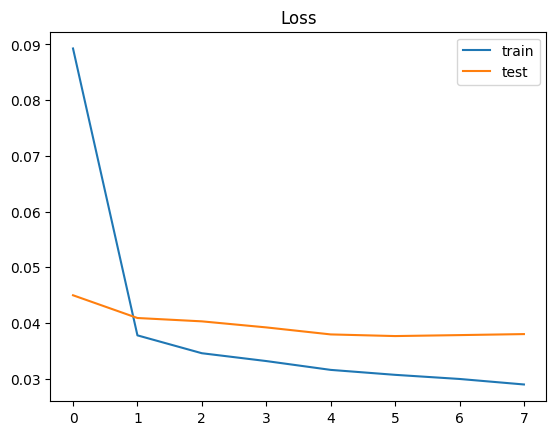

88/88 [==============================] - 0s 3ms/step - loss: 0.0331 - accuracy: 0.9887
Test set
  Loss: 0.033
  Accuracy: 0.989


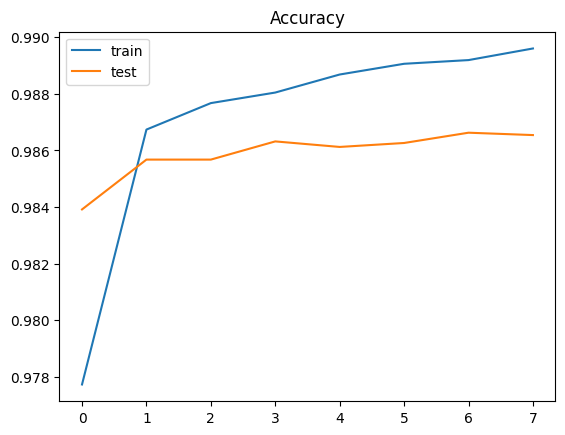

In [23]:
epochs = 10
batch_size = 16

history = model.fit(
    X_train, y_train, 
    epochs=epochs, batch_size=batch_size, 
    validation_split=0.1, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)]
    )


### VISUALIZING TRAINING and TESTING ###
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [25]:
### SAVING THE MODEL

model_path = os.path.join(os.path.dirname(os.getcwd()), "models")

try:
    # nekad budu errori zbog tensorflowa :) kad se koristi dropout
    model.save(os.path.join(model_path, model_name), save_format="tf")

except:
    model.save(os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(__file__))), "saved_models", (model_name+'.h5')))
    print("model {} saved as .h5 keras format".format(model_name))

INFO:tensorflow:Assets written to: /home/dario/Projects/lipik-nlp/models/rnn1_token_2/assets


INFO:tensorflow:Assets written to: /home/dario/Projects/lipik-nlp/models/rnn1_token_2/assets


In [ ]:
### preporuča se uvijek koristiti 'SavedModel' format umjesto '.h5' formata (https://www.tensorflow.org/guide/keras/save_and_serialize#keras_h5_format)
model.save(os.path.join(os.getcwd(), 'models', 'saved_models', model_name), save_format='tf')

